In [2]:
%matplotlib inline

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym

import pycollocation

import inputs
import models
import solvers
import shooting

In [4]:
pycollocation.__version__

'0.2.1-alpha'

In [193]:
def get_initial_mus(assortativity, xs, exp):    
    """
    Guess that mu(x) is a linear transform of some power function. Where
    the intercept and slope of the linear transform are chosen so that
    initial guess satisfies the boundary conditions.
    
    """
    slope = ((firms.upper - firms.lower) / (workers.upper**exp - workers.lower**exp))
    if assortativity == "positive":
        intercept = firms.lower - slope * workers.lower**exp
    elif assortativity == "negative":
        slope = -slope
        intercept = firms.upper - slope * workers.lower**exp
    else:
        raise ValueError
    
    return intercept + slope * xs**exp

In [391]:
# define some default workers skill
x, mu1, sigma1 = sym.var('x, mu1, sigma1')
skill_cdf = 0.5 + 0.5 * sym.erf((x - mu1) / sym.sqrt(2 * sigma1**2))
skill_params = {'mu1': 0, 'sigma1': 1.0}
skill_bounds = [1e-2, 10.0]

workers = inputs.Input(var=x,
                       cdf=skill_cdf,
                       params=skill_params,
                       bounds=skill_bounds,
                       )

# define some default firms
y, mu2, sigma2 = sym.var('y, mu2, sigma2')
productivity_cdf = (0.5 + 0.5 * sym.erf((y - mu2) / sym.sqrt(2 * sigma2**2)))
productivity_params = {'mu2': 0.0, 'sigma2': 1.0}
productivity_bounds = [1e-2, 10.0]

firms = inputs.Input(var=y,
                     cdf=productivity_cdf,
                     params=productivity_params,
                     bounds=productivity_bounds,
                     )

# define symbolic expression for CES between x and y
omega_A, sigma_A, Big_A = sym.var('omega_A, sigma_A, Big_A')
A = ((omega_A * x**((sigma_A - 1) / sigma_A) + 
     (1 - omega_A) * y**((sigma_A - 1) / sigma_A))**(sigma_A / (sigma_A - 1))) 

# define symbolic expression for Cobb-Douglas between l and r
l, r, omega_B, sigma_B = sym.var('l, r, omega_B, sigma_B')
B = l**omega_B * r**(1 - omega_B)

F = Big_A * (A * B)

F_params = {'omega_A':0.5, 'omega_B':0.9, 'sigma_A':0.6, 'Big_A':1e1}

model = models.Model('positive',
                     workers=workers,
                     firms=firms,
                     production=F,
                     params=F_params)


In [392]:
mu, theta = sym.symbols('mu, theta')
rhs = {'mu': model.matching.mu_prime, 'theta': model.matching.theta_prime}

# specify some boundary conditions
bcs = {'lower': [mu - workers.lower], 'upper': [mu - workers.upper]}

bvp = pycollocation.SymbolicBoundaryValueProblem(dependent_vars=['mu', 'theta'],
                                                 independent_var='x',
                                                 rhs=rhs,
                                                 boundary_conditions=bcs,
                                                 params=model.params,  # need to use ALL params
                                                 )

In [393]:
solver2 = shooting.ShootingSolver(model=model)
solver2.solve(1e4, tol=1e-6, number_knots=1000, integrator='lsoda', atol=1e-12, rtol=1e-6, message=True)

Exhausted workers: initial guess of 5000.0 for firm size is too high!
Exhausted workers: initial guess of 2500.0 for firm size is too high!
Exhausted firms: initial guess of 1250.0 for firm size is too low.
Exhausted workers: initial guess of 1875.0 for firm size is too high!
Exhausted workers: initial guess of 1562.5 for firm size is too high!
Exhausted workers: initial guess of 1406.25 for firm size is too high!
Exhausted firms: initial guess of 1328.125 for firm size is too low.
Exhausted workers: initial guess of 1367.1875 for firm size is too high!
Exhausted firms: initial guess of 1347.65625 for firm size is too low.
Exhausted workers: initial guess of 1357.421875 for firm size is too high!
Exhausted workers: initial guess of 1352.5390625 for firm size is too high!
Exhausted workers: initial guess of 1350.09765625 for firm size is too high!
Exhausted workers: initial guess of 1348.87695312 for firm size is too high!
Exhausted workers: initial guess of 1348.26660156 for firm size 

AssertionError: Upper and lower bounds are identical: check solver tols!

In [395]:
solver2.solution.head()

,$\mu(x)$,$\theta(x)$,$w(x)$,$\pi(x)$
x,,,,
0.01,0.009992,0.000044,0.245051,0.000001
0.02,0.174022,0.132726,0.453202,0.006684
0.03,0.240518,0.173500,0.651329,0.012556
0.04,0.295330,0.204517,0.840022,0.019089
0.05,0.343521,0.232016,1.021108,0.026324


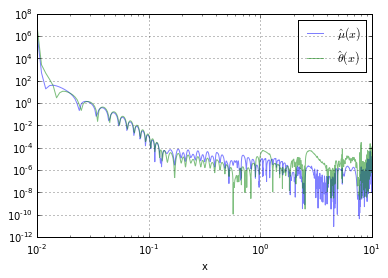

In [396]:
# Plotting the residuals
solver2.residuals.plot(loglog=True, alpha=0.5)
plt.show()

In [397]:
provisional_thetas = solver2.solution['$\\theta(x)$'].values
provisional_x = solver2.solution.index.values
provisional_mus = solver2.solution['$\\mu(x)$'].values
len(provisional_x)

1000

In [363]:
# create the solver instance
bvp_solver = pycollocation.OrthogonalPolynomialSolver(bvp)

In [398]:
# specify the domain
domain = [workers.lower, workers.upper]

# initial guess for mu(x)
xs = np.linspace(domain [0], domain[1], 100)
#mus = get_initial_mus("positive", xs, 0.5)
initial_guess_mu = np.polynomial.Chebyshev.fit(provisional_x, provisional_mus , 11, domain)

# initial guess for theta(x) should be consistent with mu(x) guess
#H = workers.evaluate_pdf(xs) / firms.evaluate_pdf(initial_guess_mu(xs))
#thetas = (H / initial_guess_mu.deriv()(xs))  # use expression for mu'(x) 
initial_guess_theta = np.polynomial.Chebyshev.fit(provisional_x, provisional_thetas, 11, domain)

# dictionary of coefficients...
initial_coefs = {'mu': initial_guess_mu.coef, 'theta': initial_guess_theta.coef}

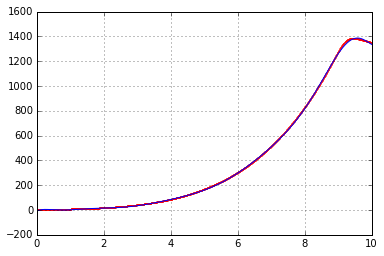

In [399]:
# quickly plot the initial conditions
plt.scatter(provisional_x, provisional_thetas, c='r', s=0.5, marker='x')
plt.plot(provisional_x, initial_guess_theta(provisional_x))
plt.xlim(domain[0], domain[1])
plt.grid('on')

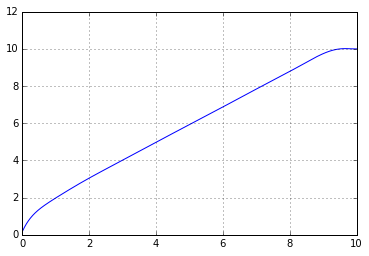

In [400]:
plt.plot(provisional_x, initial_guess_mu(provisional_x))
plt.grid('on')

In [401]:
bvp_solver.solve(kind="Chebyshev",
                 coefs_dict=initial_coefs,
                 domain=domain)
viz = pycollocation.Visualizer(bvp_solver)

In [402]:
bvp_solver.result['success']

False

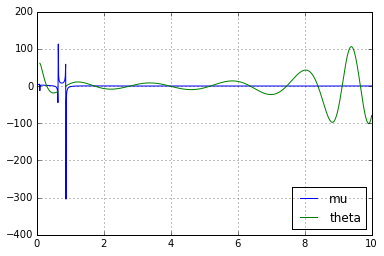

In [403]:
viz.interpolation_knots = np.linspace(domain[0], domain[1], 1000)
viz.residuals.plot()

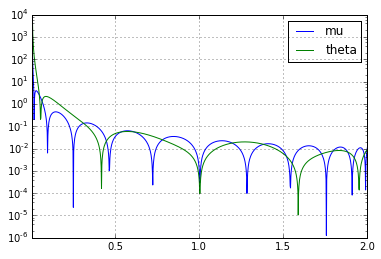

In [370]:
viz.normalized_residuals.plot(logy=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000241500F0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000000244BB4A8>], dtype=object)

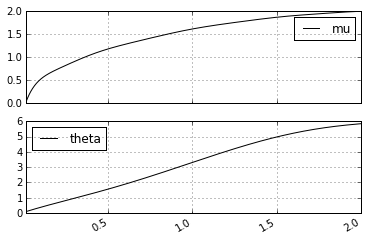

In [371]:
viz.solution.plot(subplots=True)

# Experimental section on widgets...

In [406]:
from IPython.html.widgets import interact, fixed
from IPython.html import widgets

In [407]:
initial_coefs = {'mu': initial_guess_mu.coef, 'theta': initial_guess_theta.coef}

def plot_equilibrium(bvp, mu1=0.0, sigma1=1.0,
                     mu2=0.0, sigma2=1.0,
                     omega_A=0.5, sigma_A=0.5,
                     omega_B=0.5, sigma_B=0.5):
    bvp.params.update({'omega_A':omega_A, 'omega_B':omega_B,
                       'sigma_A':sigma_A, 'sigma_B':sigma_B,
                       'loc1': -1.0, 'mu1': mu1, 'sigma1': sigma1,
                       'loc2': -1.0, 'mu2': mu2, 'sigma2': sigma2})
    
    bvp_solver = pycollocation.OrthogonalPolynomialSolver(bvp)
    #global initial_coefs
    bvp_solver.solve(kind="Chebyshev",
                     coefs_dict=initial_coefs,
                     domain=domain)
    viz = pycollocation.Visualizer(bvp_solver)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))
    viz.interpolation_knots = np.linspace(domain[0], domain[1], 1000)
    
    viz.normalized_residuals.plot(logy=True, ax=axes[0])
    axes[0].set_title("Normalized residuals")
    axes[0].set_xlabel("$x$")
    
    viz.solution.plot(logy=True, ax=axes[1])
    axes[1].set_title("Solution functions")
    axes[1].set_xlabel("$x$")
    
    # use hot start ??
    #initial_coefs = bvp_solver.coefficients
    


In [409]:
interact(plot_equilibrium,
         bvp=fixed(model),
         omega_A=(0.0, 1.0, 1e-2),
         omega_B=(0.0, 1.0, 1e-2),
        )

AttributeError: Attribute 'model' must have type BoundaryValueProblem, not <class 'models.Model'>

<function __main__.plot_equilibrium>